In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import collections
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 15

In [48]:
video_path = '../data/video/eye_lighter.mp4'
cap = cv2.VideoCapture(video_path)

In [52]:
cap.get(cv2.CAP_PROP_FRAME_WIDTH)
cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

0.0

In [50]:
video_path = '../data/video/calib.mp4'
cap = cv2.VideoCapture(video_path)

frames = []
idx = 0
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break
    if idx % 100==0:
        frames.append(frame)
    idx += 1

# When everything done, release the capture
cap.release()

In [16]:
len(frames)

56

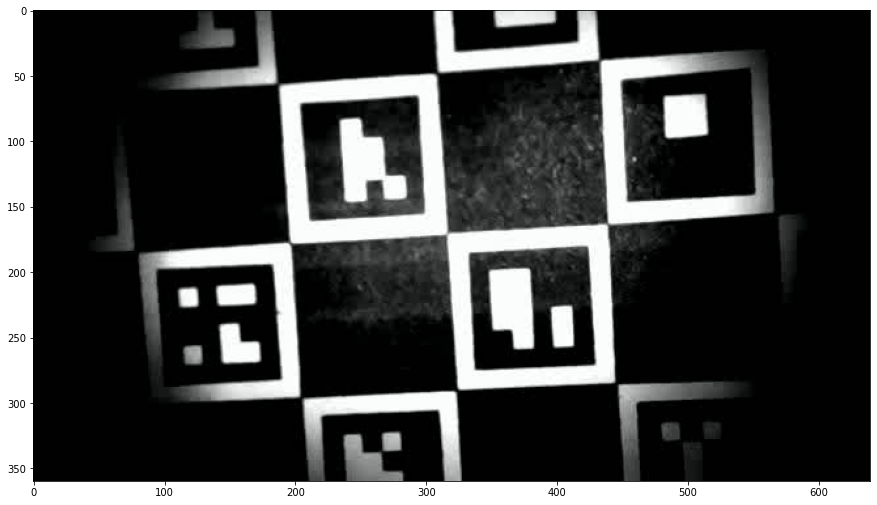

In [17]:
plt.imshow(frames[0])

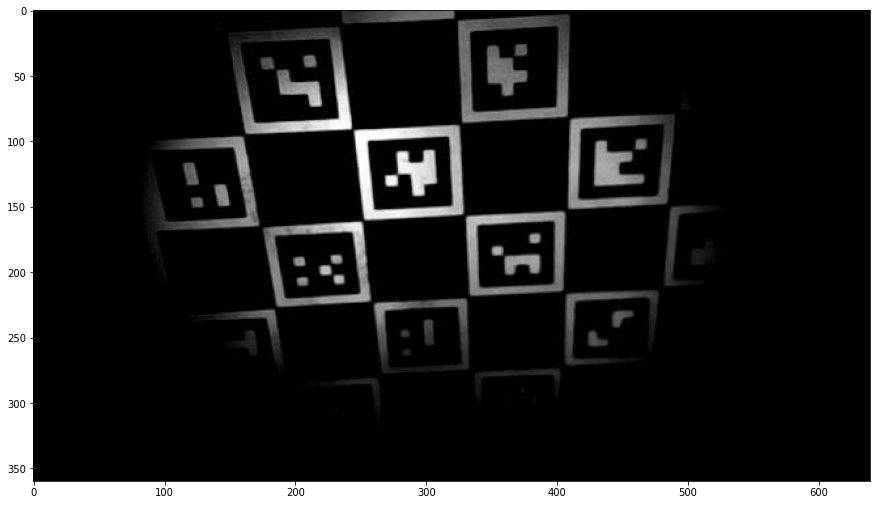

In [19]:
plt.imshow(frames[-10])

In [29]:
def normalize(img):
    img = img.astype(np.float32)
    min_val, max_val = np.min(img), np.max(img)
    img = (img - min_val) / (max_val - min_val) * 255
    return img.astype(np.uint8)

save_path = './tmp'
for i in range(len(frames)):
    img = frames[i].copy()
    h, w, _ = img.shape
    gray = normalize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    parameters =  cv2.aruco.DetectorParameters_create()
    parameters.adaptiveThreshWinSizeMax = 20
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

    board = cv2.aruco.CharucoBoard_create(10, 10, 0.01, 0.007, aruco_dict)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1e-5)

    if len(corners)>0:
        # SUB PIXEL DETECTION
        for corner in corners:
            cv2.cornerSubPix(gray, corner,
                             winSize = (5,5),
                             zeroZone = (-1,-1),
                             criteria = criteria)

        res2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)

    vis = cv2.aruco.drawDetectedMarkers(image=img.copy(), corners=corners, ids=ids)
    out_path = osp.join(save_path, '{}_frame.png'.format(i))
    cv2.imwrite(out_path, vis)

In [36]:
def read_chessboards(frames):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0

    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    board = cv2.aruco.CharucoBoard_create(10, 10, 0.01, 0.007, aruco_dict)
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for frame in frames:
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, aruco_dict)

        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,frame,board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

        decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize

allCorners,allIds,imsize=read_chessboards(frames)

POSE ESTIMATION STARTS:


In [37]:
def calibrate_camera(allCorners,allIds,imsize):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    #flags = (cv2.CALIB_RATIONAL_MODEL)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [38]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: user 20.2 s, sys: 0 ns, total: 20.2 s
Wall time: 20.2 s


In [39]:
ret

0.5508089507025886

In [40]:
mtx

array([[946.02826404,   0.        , 163.55142961],
       [  0.        , 946.02826404, 321.84027811],
       [  0.        ,   0.        ,   1.        ]])

In [41]:
dist

array([[-0.24276612],
       [ 0.06406483],
       [-0.00619514],
       [ 0.00345182],
       [ 1.59283623],
       [ 0.26423212],
       [-0.13359826],
       [-2.85381027],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])